<a href="https://colab.research.google.com/github/romenlaw/gan/blob/main/GANs_in_Slanted_Land.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Networks in Slanted Land

This notebook is from https://github.com/luisguiserrano/gans/blob/master/GANs_in_Slanted_Land.ipynb

In this notebook, we build a very simple pair of GANs.
- The dataset is a dataset of 2x2 black and white images, where the images we want to generate (the faces) are backwards diagonals (\\)
- The neural networks only have one layer.

Below is the YouTube video corresponding to this notebook.

In [1]:
import IPython
IPython.display.IFrame("https://www.youtube.com/watch?v=8L11aMN5KY8", 560, 315)

### Imports

In [2]:
# Imports

import numpy as np
from numpy import random
from matplotlib import pyplot as plt
%matplotlib inline

### Plotting function

In [3]:
# Drawing function

def view_samples(samples, m, n):
  """
  samples - a list of 2x2 pixel images to be plotted. The dim of each element is
    reshaped in this function, so it does not matter if the input is (4,) or (2,2)
  m - number of subplot rows in a pyplot
  n - number of subplot columns in a pyplot
  This function only plots mxn elements in the samples list, and discards the rest.
  """
  fig, axes = plt.subplots(figsize=(5, 5), nrows=m, ncols=n, sharey=True, sharex=True)
  for ax, img in zip(axes.flatten(), samples):
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    im = ax.imshow(1-img.reshape((2,2)), cmap='Greys_r')
  return fig, axes

# Examples of faces

In the video, we've defined the faces as backwards diagonals. Here are some examples.

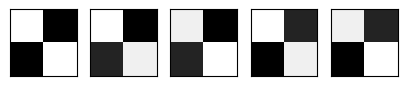

In [18]:
# Examples of faces
# faces = [np.array([1,0,0,1]),
#          np.array([0.9,0.1,0.2,0.8]),
#          np.array([0.9,0.2,0.1,0.8]),
#          np.array([0.8,0.1,0.2,0.9]),
#          np.array([0.8,0.2,0.1,0.9])]

# let's try slant the other way
faces = [np.array([0,1,1,0]),
         np.array([0.1,0.9,0.8,0.2]),
         np.array([0.2,0.9,0.8,0.1]),
         np.array([0.1,0.8,0.9,0.2]),
         np.array([0.2,0.8,0.9,0.1])]

_ = view_samples(faces, 1, 5)

# Examples of noise
The following are randomly generated images, which don't correspond to faces.

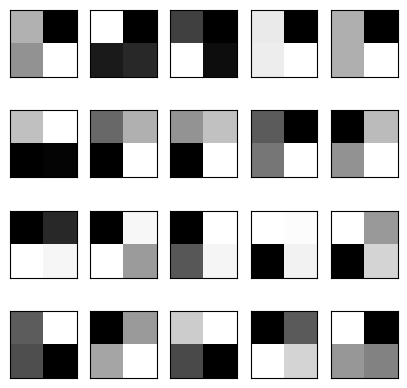

In [19]:
# Examples of noisy images
# noise = [np.random.randn(2,2) for i in range(20)]
def generate_random_image():
  return [np.random.random(), np.random.random(), np.random.random(), np.random.random()]

noise = [np.array(generate_random_image()) for _ in range(20)]
_ = view_samples(noise, 4,5)

# Building the neural networks

definition of sigmoid:
$$\sigma(x) = \dfrac{1}{1+e^{-x}}
$$
Derivative of sigmoid:
$$\sigma'(x) = \sigma(x)[1-\sigma(x)]
$$

In [8]:
# The sigmoid activation function
def sigmoid(x):
    return 1.0/(1.0+np.exp(-x))

## The Discriminator

<img src="https://github.com/luisguiserrano/gans/blob/master/discriminator_math.png?raw=1" />

In [7]:
class Discriminator():
    def __init__(self):
        #self.weights = np.array([0.0 for i in range(4)])
        #self.bias = 0.0
        self.weights = np.array([np.random.normal() for i in range(4)])
        self.bias = np.random.normal()

    def forward(self, x): # dim of x is (4,)
        # Forward pass
        return sigmoid(np.dot(x, self.weights) + self.bias)

    def error_from_image(self, image): # dim of image is (4,)
        prediction = self.forward(image)
        # We want the prediction to be 1, so the error is -log(prediction)
        return -np.log(prediction)

    def derivatives_from_image(self, image):
        prediction = self.forward(image)
        derivatives_weights = -image * (1-prediction)
        derivative_bias = -(1-prediction)
        return derivatives_weights, derivative_bias

    def update_from_image(self, x):
        d_weights, d_bias = self.derivatives_from_image(x)
        self.weights -= learning_rate * d_weights
        self.bias -= learning_rate * d_bias

    def error_from_noise(self, noise):
        prediction = self.forward(noise)
        # We want the prediction to be 0, so the error is -log(1-prediction)
        return -np.log(1-prediction)

    def derivatives_from_noise(self, noise):
        prediction = self.forward(noise)
        derivatives_weights = noise * prediction
        derivative_bias = prediction
        return derivatives_weights, derivative_bias

    def update_from_noise(self, noise):
        ders = self.derivatives_from_noise(noise)
        self.weights -= learning_rate * ders[0]
        self.bias -= learning_rate * ders[1]

## The Generator
<img src="https://github.com/luisguiserrano/gans/blob/master/generator_math.png?raw=1" />

In [10]:
class Generator():
    def __init__(self):
        self.weights = np.array([np.random.normal() for i in range(4)])
        self.biases = np.array([np.random.normal() for i in range(4)])

    def forward(self, z): # z is scalar
        # Forward pass
        return sigmoid(z * self.weights + self.biases)

    def error(self, z, discriminator):
        x = self.forward(z)
        # We want the prediction to be 0, so the error is -log(1-prediction)
        y = discriminator.forward(x)
        return -np.log(y)

    def derivatives(self, z, discriminator):
        discriminator_weights = discriminator.weights
        discriminator_bias = discriminator.bias
        x = self.forward(z)
        y = discriminator.forward(x)
        factor = -(1-y) * discriminator_weights * x *(1-x)
        derivatives_weights = factor * z
        derivative_bias = factor
        return derivatives_weights, derivative_bias

    def update(self, z, discriminator):
        error_before = self.error(z, discriminator)
        d_weights, d_bias = self.derivatives(z, discriminator)
        self.weights -= learning_rate * d_weights
        self.biases -= learning_rate * d_bias
        error_after = self.error(z, discriminator)

# Training

In [20]:
# Set random seed
np.random.seed(42)

# Hyperparameters
learning_rate = 0.01
epochs = 1000

# The GAN
D = Discriminator()
G = Generator()

# For the error plot
errors_discriminator = []
errors_generator = []

for epoch in range(epochs):

  for face in faces:

    # Update the discriminator weights from the real face
    D.update_from_image(face)

    # Pick a random number to generate a fake face
    z = random.rand()

    # Calculate the discriminator error
    errors_discriminator.append(sum(D.error_from_image(face) + D.error_from_noise(z)))

    # Calculate the generator error
    errors_generator.append(G.error(z, D))

    # Build a fake face
    noise = G.forward(z)

    # Update the discriminator weights from the fake face
    D.update_from_noise(noise)

    # Update the generator weights from the fake face
    G.update(z, D)

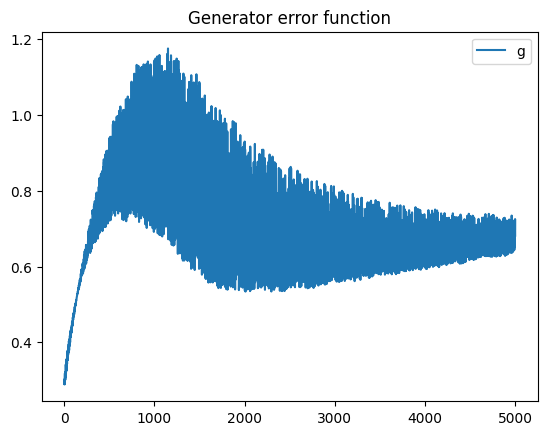

Text(0.5, 1.0, 'Discriminator error function')

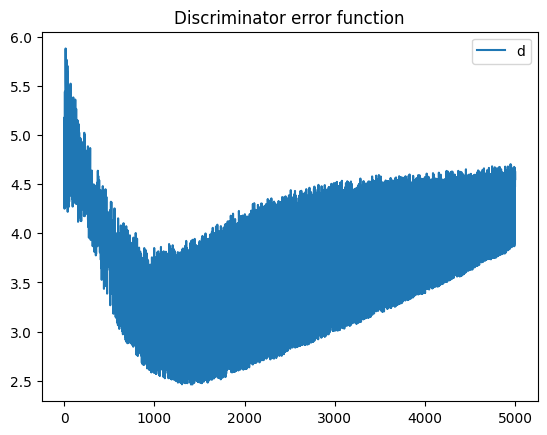

In [21]:
import matplotlib.pyplot as plt
plt.plot(errors_generator)
plt.title("Generator error function")
plt.legend("gen")
plt.show()
plt.plot(errors_discriminator)
plt.legend('disc')
plt.title("Discriminator error function")

# Generating images

[0.03050272 0.95510441 0.95952934 0.03158775]
[0.01938875 0.97752564 0.97618115 0.01981288]
[0.02593382 0.96492441 0.96651475 0.02672959]
[0.03678269 0.94043356 0.94967576 0.0382968 ]
[0.01676157 0.98203035 0.97992255 0.01705415]
[0.02395265 0.96893215 0.96948707 0.02463009]
[0.0173612  0.9810326  0.97907665 0.01768278]
[0.03201946 0.95167882 0.95717419 0.03320504]


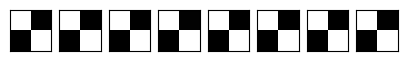

In [22]:
generated_images = []
for i in range(8):
    z = random.random()
    generated_image = G.forward(z)
    generated_images.append(generated_image)
_ = view_samples(generated_images, 1, 8)
for i in generated_images:
    print(i)

# Studying the weights and biases of the Generator and Discriminator

In [23]:
print("Generator weights", G.weights)
print("Generator biases", G.biases)

Generator weights [-1.5578018   2.39836268  1.83542343 -1.60475664]
Generator biases [-2.58699057  1.71501029  2.13849715 -2.52463451]


In [24]:
print("Discriminator weights", D.weights)
print("Discriminator bias", D.bias)

Discriminator weights [-0.43546069  0.69457121  0.32449066 -0.78035473]
Discriminator bias -0.8819278687770823
